# Ground Motion Displacement RMS vs Time

*an example simple tutorial for getting seismic data, computing the power spectral densities, extracting the RMS and plotting*

Required:

- python
- obspy (and its dependencies)
- pandas
- jupyter
- notebook

this should be easy to set up in a conda env: ``conda create -n covid python=3.7 obspy pandas jupyter notebook``

Author: Thomas Lecocq @seismotom, Fred Massin @fmassin

## Step 1: imports

In [11]:
import datetime
import os
import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.signal import PPSD


## Step 2: Define Start/End dates and Seismic Channel

You'll have to make sure the seed_id you request is indeed available from the ``data_provider``

In [12]:
start = UTCDateTime("2020-02-13")
end = UTCDateTime() # means "now"

network = "CH"
station = "SBERN,SZUZ,SGEV"#,SLOP,SUSI,SEPFL,SBAM2," # Urban stations
#station = "SEPFL,SMOE,SBUL,SIEB,SIZS,SLENK,SMEIS,SARD,SBJN,SCHAT,SEFS," # School stations, change on 1rst ban?
#station = "SCRM,SALTS,SBAS,SBRS,SCHS,SDES,SSTS,SWIS," # Hospital stations, less of a decrease than others ?
#station = "NALPS,JAUN,BRANT,FUORN" # Good free field stations, nothing?
#station = "BERNI,SIMPL," # Alpine mountain passes, people traveling on the weekend,?
location = ""
channel = "HG*"

data_provider = "ETH"
logo = plt.imread('https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Logo_SED_2014.png/220px-Logo_SED_2014.png')
bans = {"2020-03-13":'Groups >100 banned', "2020-03-20":'Groups >5 banned'}


## Step 3: Download the seismic waveform data

This step is coded so that only the last day is redownloaded iif the daily files are present on the disk.

The request gets the target day +- 30 minutes to avoid having gaps at the end of each day (need 1 window covering midnight).

In [ ]:
datelist = pd.date_range(start.datetime, end.datetime, freq="D")
c = Client(data_provider)

for day in datelist:
    fn = day.strftime("%Y-%m-%d.mseed")
    print(fn)
    if day != datelist[-1] and os.path.isfile(fn):
        continue
    else:
        st = c.get_waveforms(network, station, location, channel,
                             UTCDateTime(day)-1801, UTCDateTime(day)+86400+1801, attach_response=True)
        print(st)
        st.write(fn)
resp = c.get_stations(UTCDateTime(day), network=network, station=station, location=location,
                      channel=channel, level="response")
print(resp)


2020-02-13.mseed
33 Trace(s) in Stream:

CH.SLOP..HGE | 2020-02-12T23:29:57.932000Z - 2020-02-14T00:05:23.948000Z | 250.0 Hz, 22131505 samples
...
(31 other traces)
...
CH.SEPFL..HGZ | 2020-02-12T23:29:57.504000Z - 2020-02-14T00:30:01.920000Z | 250.0 Hz, 22501105 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/io/mseed/core.py:807: UserWarning: File will be written with more than one different encodings.
This might have a negative influence on the compatibility with other programs.
  warnings.warn(msg % 'encodings')


2020-02-14.mseed
320 Trace(s) in Stream:

CH.SLOP..HGE | 2020-02-13T23:29:58.984000Z - 2020-02-14T00:05:23.948000Z | 250.0 Hz, 531242 samples
...
(318 other traces)
...
CH.SEPFL..HGZ | 2020-02-14T09:29:54.692000Z - 2020-02-15T00:30:02.432000Z | 250.0 Hz, 13501936 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
2020-02-15.mseed
195 Trace(s) in Stream:

CH.SLOP..HGE | 2020-02-14T23:29:57.864000Z - 2020-02-15T01:05:53.220000Z | 250.0 Hz, 1438840 samples
...
(193 other traces)
...
CH.SEPFL..HGZ | 2020-02-14T23:29:58.108000Z - 2020-02-16T00:30:01.312000Z | 250.0 Hz, 22500802 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
2020-02-16.mseed
237 Trace(s) in Stream:

CH.SLOP..HGE | 2020-02-15T23:29:57.936000Z - 2020-02-16T01:12:25.164000Z | 250.0 Hz, 1536808 samples
...
(235 other traces)
...
CH.SEPFL..HGZ | 2020-02-15T23:29:58.164000Z - 2020-02-17T00:30:01.624000Z | 250.0 Hz, 22500866 samples

[Use "print(Stream.__str__(extended=True))" to pr

## Step 4: Compute PPSDs using custom paramters

These parameters are set to allow the PSDs to be "nervous", not as smooth as the default PQLX ones.

In [ ]:
for day in datelist:
    fn_in = day.strftime("%Y-%m-%d.mseed")
    if day == datelist[-1] :
        continue
    stall = read(fn_in)
    for mseedid in list(set([tr.id for tr in stall])):
        fn_out = day.strftime("%Y-%m-%d-"+mseedid+".npz")
        if os.path.isfile(fn_out):
            print("%s done already."%fn_out)
            continue
        st = stall.select(id=mseedid)
        st.attach_response(resp)
        ppsd = PPSD(st[0].stats, metadata=resp,
                    ppsd_length=1800, overlap=0.5,
                    period_smoothing_width_octaves=0.025,
                    period_step_octaves=0.0125,
                    period_limits=(0.008, 50),
                    db_bins=(-200, 20, 0.25))
        ppsd.add(st)
        ppsd.save_npz(fn_out[:-4])
        print(st)
        del st, ppsd
    del stall


## Step 5: Reload daily PSDs from the disk and create a single PPSD object:

In [5]:
ppsds={}
for day in datelist:
    for fn in glob.glob(day.strftime("%Y-%m-%d-*.npz")):
        mseedid = fn.split("-")[3][:-4]
        if mseedid not in ppsds:
            ppsds[mseedid] = PPSD.load_npz(fn,True)
        else:
            ppsds[mseedid].add_npz(fn)

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-02-14-CH.SGEV..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-02-14-CH.SGEV..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-02-14-CH.SBERN..HGE.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-02-14-CH.SZUZ..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segmen

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-02-18-CH.SGEV..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-02-18-CH.SGEV..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-02-19-CH.SZUZ..HGE.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-02-19-CH.SBERN..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segmen

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-02-23-CH.SBERN..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-02-23-CH.SZUZ..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-02-23-CH.SBERN..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-02-23-CH.SZUZ..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segme

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-02-27-CH.SZUZ..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-02-27-CH.SBERN..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-02-28-CH.SZUZ..HGE.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-02-28-CH.SBERN..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segme

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-03-CH.SZUZ..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 35/130 segments omitted in file '2020-03-03-CH.SBERN..HGE.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-03-03-CH.SGEV..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-03-CH.SGEV..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segm

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-08-CH.SBERN..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-08-CH.SGEV..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-03-08-CH.SBERN..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-09-CH.SBERN..HGE.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segm

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-13-CH.SBERN..HGE.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-03-13-CH.SBERN..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-03-13-CH.SZUZ..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-13-CH.SBERN..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segm

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-03-18-CH.SBERN..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-03-18-CH.SZUZ..HGE.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-18-CH.SZUZ..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-03-18-CH.SZUZ..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segmen

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-03-22-CH.SZUZ..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-22-CH.SZUZ..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-03-22-CH.SGEV..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-03-22-CH.SGEV..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segment

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-27-CH.SGEV..HGE.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-27-CH.SBERN..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-27-CH.SBERN..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-03-27-CH.SGEV..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segme

/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-04-01-CH.SBERN..HGE.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segments omitted in file '2020-04-01-CH.SGEV..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-04-01-CH.SGEV..HGZ.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 3/99 segments omitted in file '2020-04-01-CH.SBERN..HGN.npz' (time ranges already covered).
  warnings.warn(msg)
/Users/fmassin/anaconda3/lib/python3.5/site-packages/obspy/signal/spectral_estimation.py:1516: UserWarning: 4/99 segme

## Step 6: Standard plots:

In [9]:
[ppsd.plot(max_percentage=10) and break for mseedid, ppsd in ppsds.items()]
[ppsd.plot_temporal(0.10) and break for mseedid, ppsd in ppsds.items()]
[ppsd.plot_spectrogram(clim=(-160,-100))and break for mseedid, ppsd in ppsds.items()]

SyntaxError: invalid syntax (<ipython-input-9-5450305fc2e3>, line 1)

## Step 7: Process PSDs to extract the RMS(displacement)

This can be done for multiple filters at once (``freqs`` below):

In [10]:
# Define frequency bands of interest:
freqs = [(0.1,1.0),(1.0,20.0),(4.0,14.0),(4.0,20.0)]


def rms(s, f):
    # Parseval: the RMS in time domain is the sqrt of the integral of the power spectrum
    return np.sqrt(np.trapz(s, f))

displacement_RMS = {}
for mseedid, ppsd in ppsds.items():
    per = ppsd.period_bin_centers
    displacement_RMS[mseedid] = []
    for psd in ppsd.psd_values:
        RMS = {}
        for fmin, fmax in freqs:
            ix = np.where((per>=1.0/fmax) & (per<=1.0/fmin))

            # acceleration power spectrum in Hz
            spec = psd.copy()[ix][::-1]
            f = 1.0/per.copy()[ix][::-1]

            # remove NaNs from the list
            valid = np.where(np.isfinite(spec))[0]
            spec = spec[valid]
            f = f[valid]

            w2f = (2.0 * np.pi * f)

            # The acceleration amplitude spectrum (dB to Power! = divide by 10 and not 20!)
            amp = 10.0**(spec/10.) 

            # velocity spectrum (divide by omega**2)
            vamp = amp / w2f**2

            # displacement spectrum (divide by omega**2)
            damp =  vamp / w2f**2

            RMS["%.1f-%.1f"%(fmin, fmax)] = rms(damp, f)

        displacement_RMS[mseedid].append(RMS)
        index = pd.DatetimeIndex([d.datetime for d in ppsd.times_processed])
    displacement_RMS[mseedid] = pd.DataFrame(displacement_RMS[mseedid], index=index)
    print(mseedid," rms done.")

CH.SZUZ..HGN  rms done.
CH.SBERN..HGN  rms done.
CH.SGEV..HGE  rms done.
CH.SGEV..HGZ  rms done.
CH.SZUZ..HGE  rms done.
CH.SGEV..HGN  rms done.
CH.SBERN..HGE  rms done.
CH.SBERN..HGZ  rms done.
CH.SZUZ..HGZ  rms done.


## Step 8: Custom plot for a single frequency band:

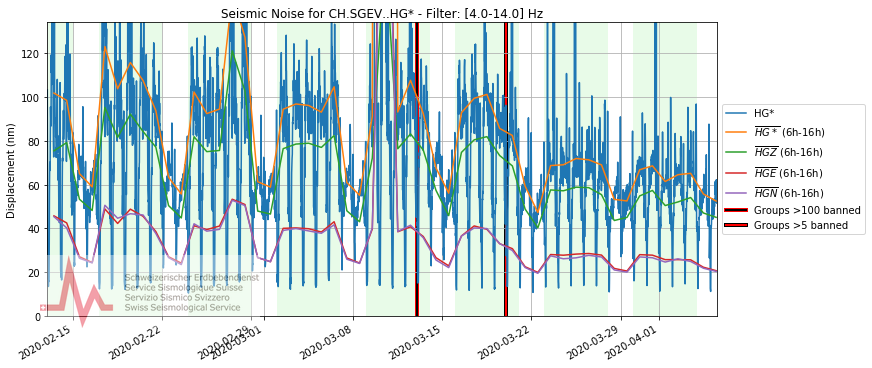

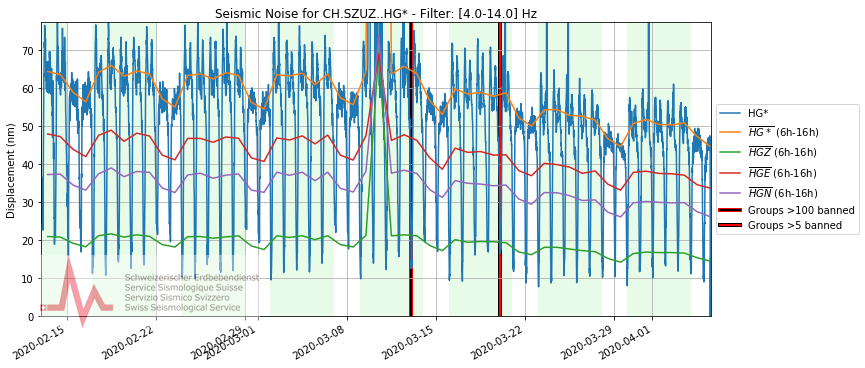

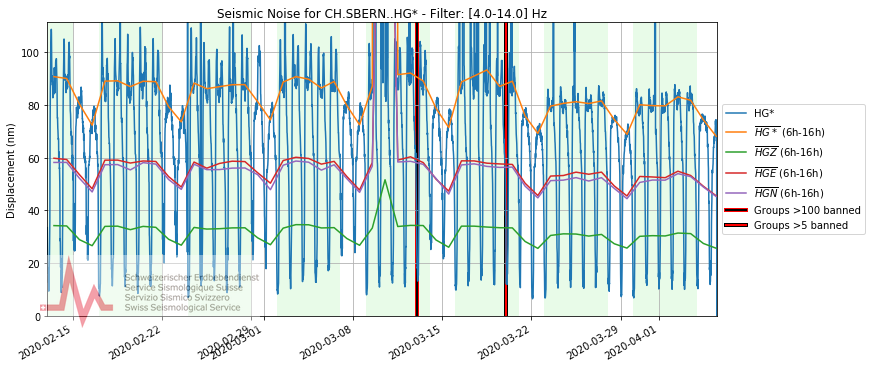

In [165]:
band = "4.0-14.0"
import matplotlib.patheffects as pe

for channelcode in list(set([k[:-1] for k in displacement_RMS])):
    fig = plt.figure(figsize=(12,6))
    try:
        fig.figimage(logo, 40, 40, alpha=.4, zorder=1)
    except:
        pass
    
    Z = displacement_RMS[channelcode+'Z'][band]
    E = displacement_RMS[channelcode+'E'][band]
    N = displacement_RMS[channelcode+'N'][band]
    codes = channelcode[-2:]
    codes = [codes+'*',codes+'Z',codes+'E',codes+'N']
    
    d = Z.copy()
    for i,t in enumerate(d.index):        
        d[i] = 0
        if len(E.index)-1<i or len(N.index)-1<i:
            break
        if (abs(E.index[0].timestamp()-N.index[0].timestamp())<60 and
            abs(Z.index[0].timestamp()-N.index[0].timestamp())<60):
            d[i] = (E[i]**2+N[i]**2+Z[i]**2)**.5
    
    plt.plot(d.index, d, label = codes[0])
    
    for i,data in enumerate([d, Z, E, N]):
        rs = data.copy().between_time("6:00", "16:00")
        rs = rs.resample("1D" ).median().tshift(12, "H")
        plt.plot(rs.index, rs, 
                 label="$\overline{%s}$ (6h-16h)"%codes[i])#, c='purple')

    

    # Get normal business days and set their background color to green
    db = pd.bdate_range(start.datetime, end.datetime)
    for dbi in db:
        plt.axvspan(dbi, dbi+datetime.timedelta(days=1),
                    facecolor='lightgreen', edgecolor="none",
                    alpha=0.2, zorder=-10)

    scale = 1e9
    plt.ylim(0,np.percentile(d,95)*1.1)
    ticks = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x*scale))
    plt.gca().yaxis.set_major_formatter(ticks)
    plt.ylabel("Displacement (nm)")

    plt.title('Seismic Noise for %s - Filter: [%s] Hz' % (channelcode+'*',
                                                          band))
    plt.xlim(d.index.min(), d.index.max())
    fig.autofmt_xdate()
    plt.grid(True, zorder=-1)
    plt.gca().set_axisbelow(True)    
    for iban,ban in enumerate(bans.keys()):
        plt.axvline(UTCDateTime(ban).datetime,
                    color='r', 
                    linewidth=2,
                    linestyle=['-', '--', '-.', ':'][iban],
                    path_effects=[pe.withStroke(linewidth=4, foreground="k")],
                    zorder=-9,
                    label=bans[b])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    fig.savefig(channelcode+".pdf",bbox_inches='tight')
    fig.savefig(channelcode+".png",bbox_inches='tight')